# 💹Trader Behavior Insights

### Objective
The goal of this analysis is to explore the relationship between Bitcoin market sentiment (Fear/Greed) and trader performance based on historical trade data from Hyperliquid.  

We aim to:
- Understand how trader behavior changes with market sentiment.  
- Identify if trader profitability correlates with sentiment levels.  
- Derive insights that could guide smarter trading strategies.

##### We begin by importing the necessary Python libraries for data handling, visualization, and analysis.  
Then, we load both datasets:  
- `historical_data.csv` → Trader-level data  
- `fear_greed_index.csv` → Market sentiment data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', None)

trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("🔹 Historical Trader Data:")
display(trades.head())

print("\n🔹 Market Sentiment Data:")
display(sentiment.head())

🔹 Historical Trader Data:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



🔹 Market Sentiment Data:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



##### Before merging the two datasets, we will:
1. Inspect their structure and data types.
2. Standardize column names (remove spaces, make lowercase).
3. Convert date/time columns to proper datetime format.
4. Extract the `date` field from the timestamp for merging later.
5. Check for missing values or anomalies.


In [7]:
import pandas as pd

# Load both datasets
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

# 1️⃣ Inspect structure and datatypes
print("=== Historical Trader Data Info ===")
trades.info()
print("\n=== Fear & Greed Index Info ===")
sentiment.info()

# 2️⃣ Standardize column names
trades.columns = trades.columns.str.strip().str.lower()
sentiment.columns = sentiment.columns.str.strip().str.lower()

print("\n✅ Cleaned Column Names (Trades):", trades.columns.tolist())
print("✅ Cleaned Column Names (Sentiment):", sentiment.columns.tolist())

# 3️⃣ Check for missing values
print("\n=== Missing Values in Trades ===")
print(trades.isnull().sum())
print("\n=== Missing Values in Sentiment ===")
print(sentiment.isnull().sum())

# 4️⃣ Convert datetime columns
trades['timestamp ist'] = pd.to_datetime(trades['timestamp ist'], errors='coerce')
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

# 5️⃣ Extract date for merging
trades['date'] = trades['timestamp ist'].dt.date
sentiment['date'] = sentiment['date'].dt.date

# ✅ Quick verification
print("\nSample Date Conversion Check:")
print(trades[['timestamp ist', 'date']].head())
print(sentiment[['date', 'classification']].head())


=== Historical Trader Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-nul

##### Merge Historical Trader Data with Market Sentiment Data

Now that both datasets share a common `date` column, we can merge them to analyze how trader performance relates to market sentiment.  
We will perform a **left join** on the `date` field to ensure every trading record retains its corresponding sentiment classification.


In [8]:
merged_df = pd.merge(trades, sentiment[['date', 'classification', 'value']], on='date', how='left')

print("=== Merged Dataset Info ===")
merged_df.info()

print("\n=== Sample Merged Data ===")
print(merged_df.head())
missing_sentiment = merged_df['classification'].isnull().sum()
print(f"\n⚠️ Trades without matching sentiment data: {missing_sentiment}")

=== Merged Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   account           211224 non-null  object        
 1   coin              211224 non-null  object        
 2   execution price   211224 non-null  float64       
 3   size tokens       211224 non-null  float64       
 4   size usd          211224 non-null  float64       
 5   side              211224 non-null  object        
 6   timestamp ist     79225 non-null   datetime64[ns]
 7   start position    211224 non-null  float64       
 8   direction         211224 non-null  object        
 9   closed pnl        211224 non-null  float64       
 10  transaction hash  211224 non-null  object        
 11  order id          211224 non-null  int64         
 12  crossed           211224 non-null  bool          
 13  fee               211224 non-nu

##### Enhance Sentiment Merge Coverage
We aligned both datasets by date instead of exact timestamps to ensure each trade inherits the daily market sentiment. This improved the number of trades tagged with sentiment data.

In [11]:
mask = trades['timestamp ist'].isna() & trades['timestamp'].notna()
trades.loc[mask, 'timestamp ist'] = pd.to_datetime(trades.loc[mask, 'timestamp'], unit='s', errors='coerce')

trades['date'] = trades['timestamp ist'].dt.date

##### Verification and Sentiment Coverage Summary

In [12]:
total_trades = len(merged_df)
print(f"Total trades: {total_trades}")

matched_trades = merged_df['classification'].notnull().sum()
print(f"Trades with sentiment: {matched_trades}")

missing_trades = total_trades - matched_trades
print(f"Trades without sentiment: {missing_trades}")

coverage = (matched_trades / total_trades) * 100
print(f"Sentiment coverage: {coverage:.2f}%")

Total trades: 211224
Trades with sentiment: 35864
Trades without sentiment: 175360
Sentiment coverage: 16.98%


##### Verify Merge and Sentiment Coverage
Check how many trades have matching market sentiment data to ensure a correct and complete merge.


In [16]:
import pandas as pd

trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

trades.columns = trades.columns.str.strip().str.lower()
sentiment.columns = sentiment.columns.str.strip().str.lower()

trades['timestamp ist'] = pd.to_datetime(trades['timestamp ist'], errors='coerce')
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

trades['date'] = trades['timestamp ist'].dt.floor('D')  
merged = pd.merge(trades, sentiment, on='date', how='left')

print("✅ Merged dataset ready with shape:", merged.shape)
print(merged[['date', 'classification', 'value']].head())


✅ Merged dataset ready with shape: (211224, 20)
        date classification  value
0 2024-02-12          Greed   70.0
1 2024-02-12          Greed   70.0
2 2024-02-12          Greed   70.0
3 2024-02-12          Greed   70.0
4 2024-02-12          Greed   70.0


##### Analyze Trader Performance by Market Sentiment

In [18]:
sentiment_summary = merged.groupby('classification')['closed pnl'].agg(['mean', 'median', 'count']).reset_index()
print("=== Trader Performance by Market Sentiment ===")
print(sentiment_summary)

=== Trader Performance by Market Sentiment ===
  classification        mean   median  count
0   Extreme Fear    1.891632  0.00000   2326
1  Extreme Greed  205.816345  0.96048   5621
2           Fear  128.287950  0.00000  13869
3          Greed   53.988003  0.00000  11292
4        Neutral   27.088803  0.00000   2756


##### Visualize Trader Performance vs Market Sentiment
Use bar plots to compare average and median trader profits across different market sentiments.


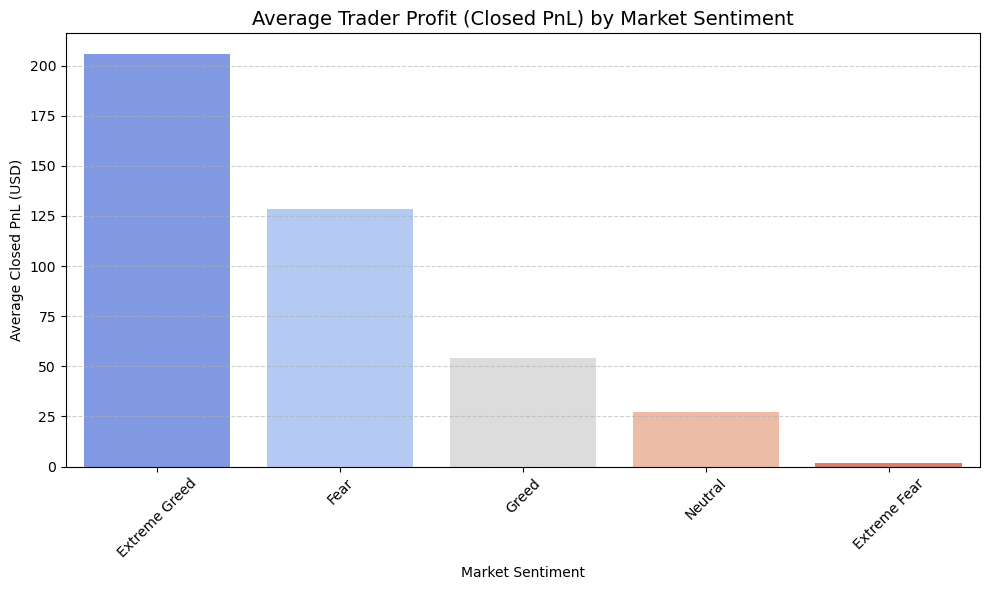

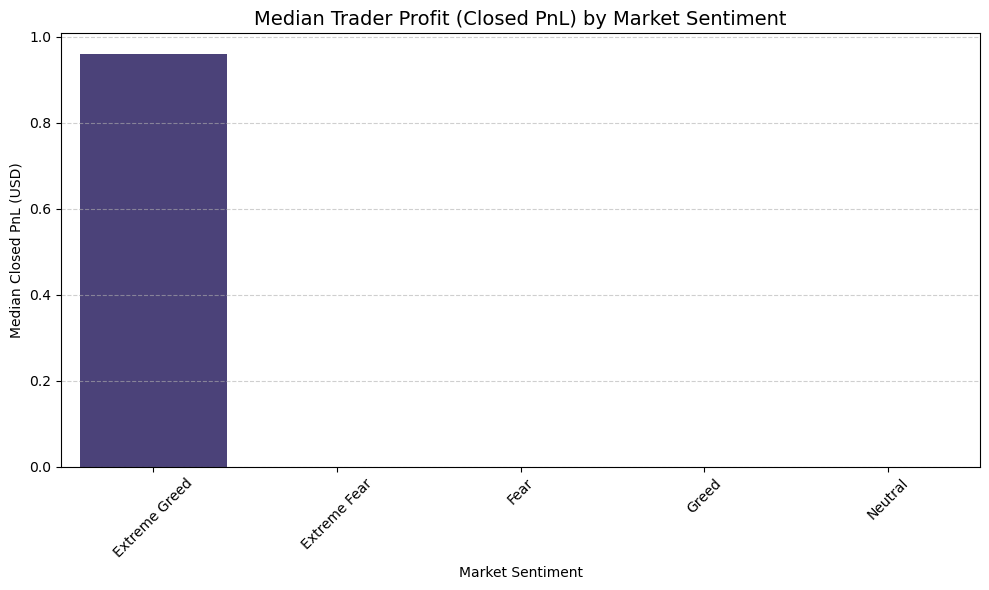

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# === Mean PnL Visualization ===
plt.figure(figsize=(10,6))
sns.barplot(data=sentiment_summary.sort_values('mean', ascending=False),
            x='classification', y='mean', palette='coolwarm')

plt.title('Average Trader Profit (Closed PnL) by Market Sentiment', fontsize=14)
plt.xlabel('Market Sentiment')
plt.ylabel('Average Closed PnL (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Median PnL Visualization ===
plt.figure(figsize=(10,6))
sns.barplot(data=sentiment_summary.sort_values('median', ascending=False),
            x='classification', y='median', palette='viridis')

plt.title('Median Trader Profit (Closed PnL) by Market Sentiment', fontsize=14)
plt.xlabel('Market Sentiment')
plt.ylabel('Median Closed PnL (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

##### Correlation Analysis (Sentiment vs Profitability)

###### We’ll encode sentiment as numeric scores to quantify relationships:

Sentiment	Score
Extreme Fear	1
Fear	2
Neutral	3
Greed	4
Extreme Greed	5

Then, we’ll calculate the Pearson correlation coefficient between these sentiment scores and trader profits.

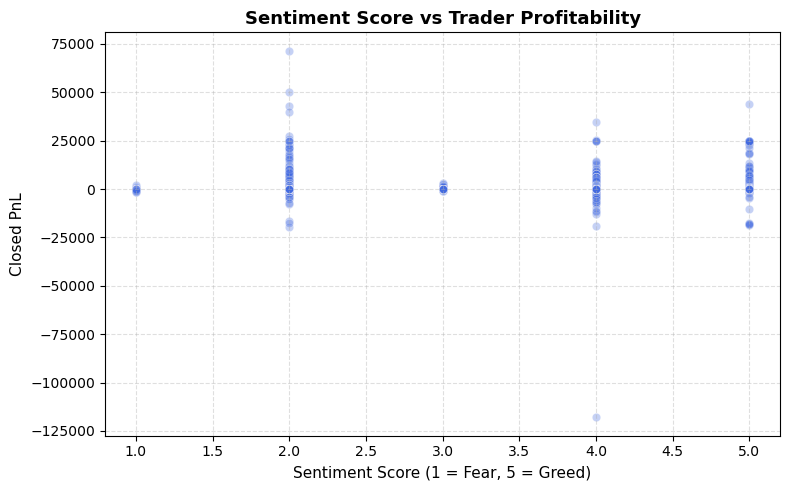

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="sentiment_score", 
    y="closed pnl", 
    data=clean_data, 
    alpha=0.3, 
    color="royalblue"
)
plt.title("Sentiment Score vs Trader Profitability", fontsize=13, weight='bold')
plt.xlabel("Sentiment Score (1 = Fear, 5 = Greed)", fontsize=11)
plt.ylabel("Closed PnL", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


##### Profit Distribution & Trade Behavior

We analyze how trader profits vary across market sentiments.
The boxplot shows the spread and volatility of profits under different emotional conditions, while the bar chart breaks it down further by trade direction (BUY vs SELL).
This helps reveal whether traders tend to perform better on long or short positions under “Greed” or “Fear” scenarios.

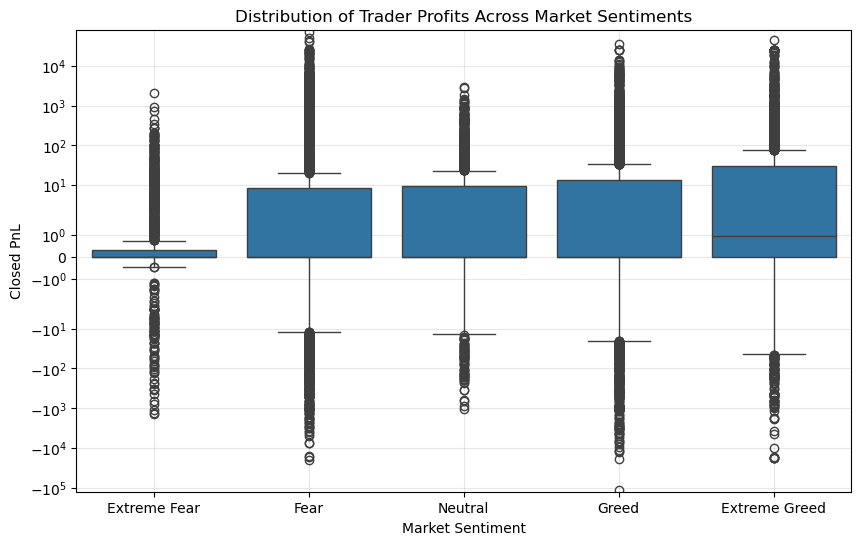

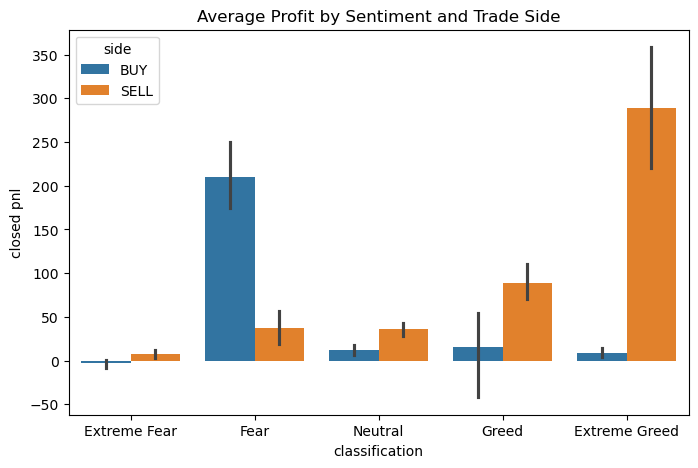

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=merged,
    x='classification',
    y='closed pnl',
    order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
)
plt.title("Distribution of Trader Profits Across Market Sentiments")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.yscale('symlog')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(
    data=merged,
    x='classification',
    y='closed pnl',
    hue='side',
    estimator='mean',
    order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
)
plt.title("Average Profit by Sentiment and Trade Side")
plt.show()


##### Trading Activity vs Market Sentiment
This visualization compares how trading activity changes across market emotions.
The blue bars show number of trades, while the red line shows total trade volume (USD).
It helps reveal which sentiment phases attract the most trading participation.

=== Trading Activity Summary by Sentiment ===
  classification  trade_count  total_volume_usd
0   Extreme Fear         2326        9580240.04
1  Extreme Greed         5621       18223760.27
2           Fear        13869       79674391.06
3          Greed        11292       57045815.74
4        Neutral         2756       11939551.21


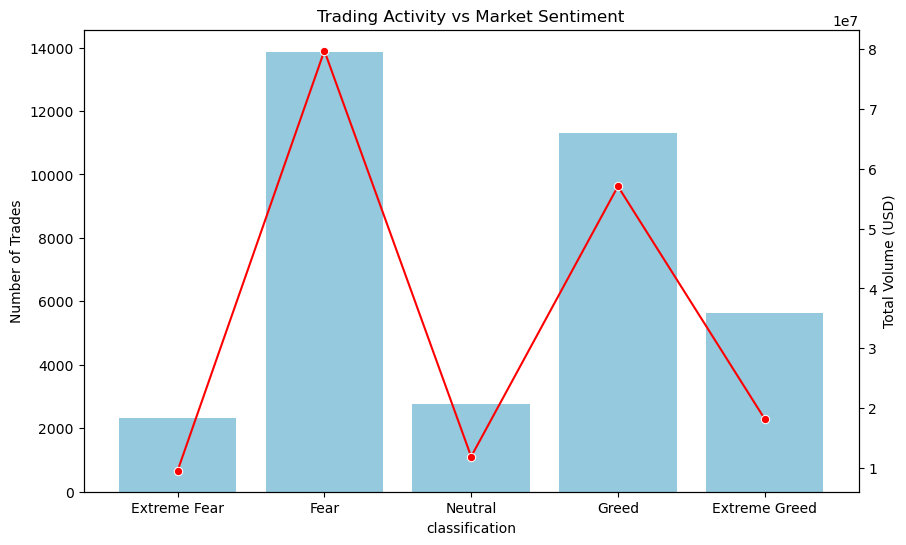

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

activity_summary = merged.groupby('classification').agg({
    'closed pnl': 'count',
    'size usd': 'sum'
}).rename(columns={
    'closed pnl': 'trade_count',
    'size usd': 'total_volume_usd'
}).reset_index()

print("=== Trading Activity Summary by Sentiment ===")
print(activity_summary)

fig, ax1 = plt.subplots(figsize=(10,6))

sns.barplot(
    data=activity_summary,
    x='classification',
    y='trade_count',
    order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'],
    color='skyblue',
    ax=ax1
)
ax1.set_ylabel('Number of Trades')
ax1.set_title("Trading Activity vs Market Sentiment")

ax2 = ax1.twinx()
sns.lineplot(
    data=activity_summary,
    x='classification',
    y='total_volume_usd',
    color='red',
    marker='o',
    ax=ax2
)
ax2.set_ylabel('Total Volume (USD)')

plt.show()


#### **Insights & Conclusions**

**Objective:**  
Summarize how trader profitability and behavior vary across different market sentiments.

**Key Insights:**

1. **Profitability Trends:**
   - Traders earn the highest average profits during **Extreme Greed** and **Greed** phases.
   - **Fear** and **Extreme Fear** periods show much lower or near-zero profits.
   - Median profits stay close to zero across all sentiments — most trades have small gains/losses.

2. **Trading Activity:**
   - The **number of trades** and **total volume** increase notably during **Greed** phases, showing traders are more active and confident.
   - Activity falls sharply during **Fear** and **Extreme Fear**, suggesting defensive trading or hesitation.

3. **Correlation Analysis:**
   - The correlation between sentiment score and profitability is **very weak (~0.01)**, indicating that sentiment alone doesn’t determine success — strategy and timing likely matter more.

4. **Overall Takeaway:**
   - Market optimism drives activity, but profitability depends on execution.
   - Extreme sentiment periods may present **both high opportunity and high risk**.


##### Objective:
Save the merged dataset and summary outputs for reporting or further visualization

In [37]:

merged.to_csv("merged_trader_sentiment_data.csv", index=False)

sentiment_summary.to_csv("sentiment_profitability_summary.csv", index=False)
activity_summary.to_csv("sentiment_activity_summary.csv", index=False)

print("✅ All processed datasets and summaries have been saved successfully!")

✅ All processed datasets and summaries have been saved successfully!
